# Przygotowanie środowiska
Podłączenie Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
#!pip install re 


Importy

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# from cleaning import text_tokenizer, plot_table_most_important, top_tokens, wordcloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# cleaning file imports
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk import PorterStemmer
from nltk.corpus import stopwords
from prettytable import PrettyTable
from wordcloud import WordCloud
from datetime import datetime

In [4]:
# nltk.download('stopwords')


# Funkcje przetwarzania tekstu

*   `text_preparing()` - oczyszczanie regex;
*   `cleaning_words()` - usuwanie stopwords;
* `stemming()` - usuwanie końcówek;
* `longer_words()` - usuwanie słów krotszych niż 3 znaki;
* `bag_of_words()` - words counter
* `text_tokenizer` - tokenizacja słów;
* `top_tokens()` - najczęściej padające tokeny;
* `plot_table_most_important()` - top10 wystepujacych tokenów w formie tabeli;
* `wordCloud()` - generowanie WordCloud.




In [21]:
# cleaning file
def text_prepering(x: str)-> str:
    x = re.sub('([;:]+[)(><-]+)', ' ', x)
    x = x.lower()
    x = re.sub(r'\d', ' ', x)
    x = re.sub('<[^>]+>', ' ', x)
    x = re.sub(r'[^\w\s]+', ' ', x)
    x = re.sub(r'\s{2,}', ' ', x)
    return x


def cleaning_words(tekst: list) -> list:
    stop_words = stopwords.words("english")
    lista: list = []
    for word in tekst:
        if word not in stop_words:
            lista.append(word)
    return lista


def stemming(wyrazenie: str) -> list:
    porter = PorterStemmer()
    list_tekst = wyrazenie.split(' ')
    return [porter.stem(word) for word in list_tekst]


def longer_words(lista: list) -> list:
    lista_nowa = []
    for word in lista:
        if len(word) > 3:
            lista_nowa.append(word)
    return lista_nowa


def bag_of_words(words: list) -> dict:
    bow = {}
    for word in words:
        if word not in bow.keys():
            bow[word] = 1
        else:
            bow[word] += 1
    return bow


def text_tokenizer(text) -> list:
    tekst = text_prepering(text)
    tekst = stemming(tekst)
    tekst = cleaning_words(tekst)
    tekst = longer_words(tekst)
    return tekst


def top_tokens(list_of_tokens: list, token_words: list, how_many: int) -> dict:
    top_words = []
    top_counts = []
    top_dict = {}
    for i in range(how_many):
        token_index = np.argmax(list_of_tokens)
        top_words.append(token_words[token_index])
        top_counts.append(list_of_tokens[token_index])
        list_of_tokens[token_index] = 0
        i += 1
    for key, value in zip(top_words, top_counts):
        top_dict[key] = value
    return top_dict



def plot_table_most_important(top_dict: dict, title: str):
    # plot
    words = list(top_dict.keys())[::-1]
    counts = list(top_dict.values())[::-1]
    plt.subplots(figsize=(11, 5))
    y_pos = np.arange(len(words))
    plt.barh(y_pos, counts)
    plt.yticks(y_pos, words)
    plt.ylabel("Term")
    plt.xlabel("Count")
    plt.title(title)
    plt.show()
    # pretty table
    pretty_table = PrettyTable()
    pretty_table.title = title
    pretty_table.add_column("Term", words[::-1])
    pretty_table.add_column("Count", counts[::-1])
    return pretty_table


def wordcloud(bow: list, name: str, title: str):
    bow = bag_of_words(bow)
    wc = WordCloud()
    wc.generate_from_frequencies(bow)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()
    wc.to_file(f"{name}.png")


# Analiza

In [6]:
# start_time = datetime.now()
# print(start_time)

Wczytanie datasetu i podstawowe informacje

In [7]:
df = pd.read_csv('Datasets/sentiment_tweets3.csv', usecols=['message', 'label'])

print(df.head())
print('\n')
print(df.info())
print('\n')
print(df.isnull().sum())

                                             message  label
0  just had a real good moment. i missssssssss hi...      0
1         is reading manga  http://plurk.com/p/mzp1e      0
2  @comeagainjen http://twitpic.com/2y2lx - http:...      0
3  @lapcat Need to send 'em to my accountant tomo...      0
4      ADD ME ON MYSPACE!!!  myspace.com/LookThunder      0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10314 non-null  object
 1   label    10314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.3+ KB
None


message    0
label      0
dtype: int64


In [8]:
df = df.drop_duplicates()
df = df.rename(columns={"message": "text"})

df = df.reset_index(drop=True)

Usunięcie duplikatów i przykładowe dane

In [9]:
df = df.tail(6000)
df=df.reset_index(drop=True)
print("Depresja: " + df.loc[5000, 'text'])
print('\n')
print("Brak depresji: " + df.loc[3, 'text'])
print('\n')
print("Liczebność grup")
print('\n')
print(df.groupby(['label']).size())

Depresja: the great depression prolly the best album for me to listen to right now


Brak depresji: School ... Sun please come out 


Liczebność grup


label
0    3713
1    2287
dtype: int64


Oczyszczanie tekstu 

In [10]:
df_positive = df[df['label'] == 1]
df_negative = df[df['label'] == 0]
df_general = " ".join(x for x in df.text)
df_positive_w = " ".join(x for x in df_positive.text)
df_negative_w = " ".join(x for x in df_negative.text)
df_general = text_tokenizer(df_general)
df_positive_w = text_tokenizer(df_positive_w)
df_negative_w = text_tokenizer(df_negative_w)

WordCloud

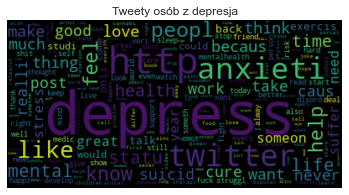

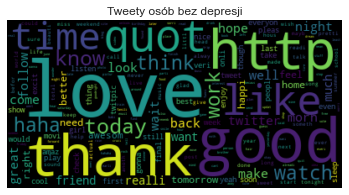

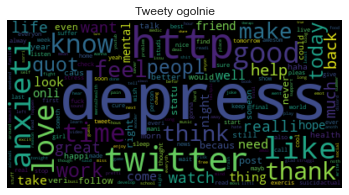

In [22]:
wordcloud(df_positive_w, "wordcloud_positive", "Tweety osób z depresja")
wordcloud(df_negative_w, "wordcloud_negative", "Tweety osób bez depresji")
wordcloud(df_general, "wordcloud_general", "Tweety ogolnie")

Wekoryzatory

In [12]:
vectorizer_count = CountVectorizer(tokenizer=text_tokenizer)
count_transform_general = vectorizer_count.fit_transform(df['text'])
count_transform_positive = vectorizer_count.fit_transform(df_positive['text'])
count_transform_negative = vectorizer_count.fit_transform(df_negative['text'])
vectorizer_tfid = TfidfVectorizer(tokenizer=text_tokenizer)
# tfid_transform_general = vectorizer_tfid.fit_transform(df['text'])
tfid_transform_positive = vectorizer_tfid.fit_transform(df_positive['text'])
tfid_transform_negative = vectorizer_tfid.fit_transform(df_negative['text'])
vectorizer_binary = CountVectorizer(tokenizer=text_tokenizer, binary=True)
# binary_transform_general = vectorizer_binary.fit_transform(df['text'])
binary_transform_positive = vectorizer_binary.fit_transform(df_positive['text'])
binary_transform_negative = vectorizer_binary.fit_transform(df_negative['text'])

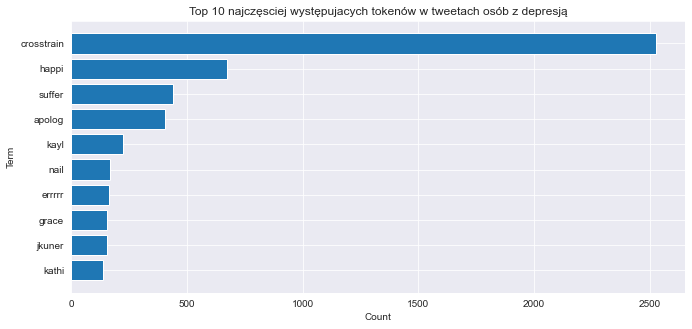

+--------------------------------------------------------+
| Top 10 najczęsciej występujacych tokenów w tweetach osób z depresją |
+------------------------------------+-------------------+
|                Term                |       Count       |
+------------------------------------+-------------------+
|             crosstrain             |        2526       |
|               happi                |        675        |
|               suffer               |        441        |
|               apolog               |        407        |
|                kayl                |        222        |
|                nail                |        169        |
|               errrrr               |        163        |
|               grace                |        156        |
|               jkuner               |        156        |
|               kathi                |        137        |
+------------------------------------+-------------------+




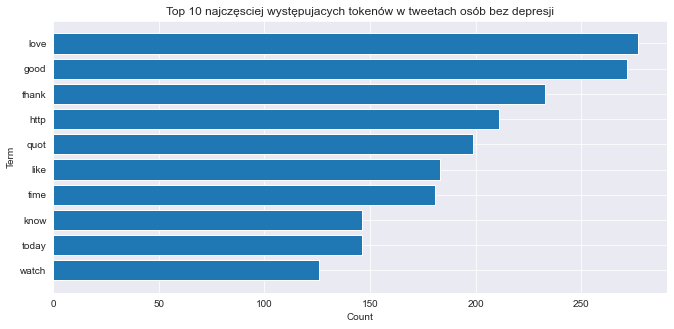

+---------------------------------------------------+
| Top 10 najczęsciej występujacych tokenów w tweetach osób bez depresji |
+-------------------------+-------------------------+
|           Term          |          Count          |
+-------------------------+-------------------------+
|           love          |           277           |
|           good          |           272           |
|          thank          |           233           |
|           http          |           211           |
|           quot          |           199           |
|           like          |           183           |
|           time          |           181           |
|           know          |           146           |
|          today          |           146           |
|          watch          |           126           |
+-------------------------+-------------------------+




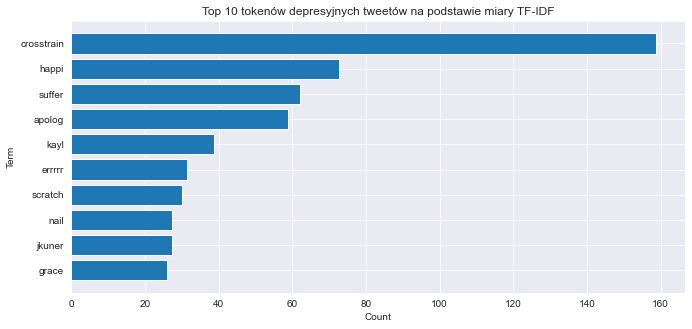

+------------------------------------------------------------+
| Top 10 tokenów depresyjnych tweetów na podstawie miary TF-IDF |
+----------------------+-------------------------------------+
|         Term         |                Count                |
+----------------------+-------------------------------------+
|      crosstrain      |          158.71409373063986         |
|        happi         |          72.60285833327553          |
|        suffer        |          62.11905160993429          |
|        apolog        |           58.7489009399523          |
|         kayl         |          38.63725964126219          |
|        errrrr        |          31.45171797214991          |
|       scratch        |          30.11075876771985          |
|         nail         |          27.35463817536819          |
|        jkuner        |          27.330671641376988         |
|        grace         |          25.99759367179971          |
+----------------------+----------------------------

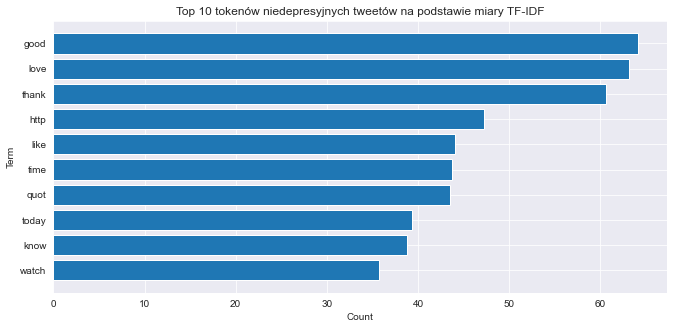

+------------------------------------------------------------+
| Top 10 tokenów niedepresyjnych tweetów na podstawie miary TF-IDF |
+--------------+---------------------------------------------+
|     Term     |                    Count                    |
+--------------+---------------------------------------------+
|     good     |               64.1320346386685              |
|     love     |              63.11550323055268              |
|    thank     |              60.602534271547015             |
|     http     |              47.220778179333344             |
|     like     |              44.02198648198333              |
|     time     |              43.759391534716855             |
|     quot     |              43.53890147121512              |
|    today     |              39.31021076743222              |
|     know     |              38.753664540101916             |
|    watch     |              35.68973514388829              |
+--------------+---------------------------------

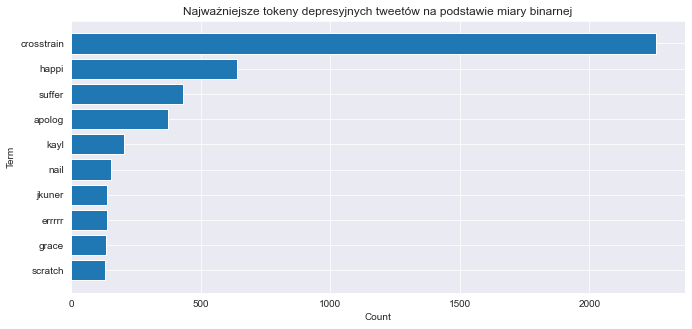

+----------------------------------------------------------+
| Najważniejsze tokeny depresyjnych tweetów na podstawie miary binarnej |
+-------------------------------------+--------------------+
|                 Term                |       Count        |
+-------------------------------------+--------------------+
|              crosstrain             |        2256        |
|                happi                |        640         |
|                suffer               |        432         |
|                apolog               |        373         |
|                 kayl                |        202         |
|                 nail                |        152         |
|                jkuner               |        140         |
|                errrrr               |        139         |
|                grace                |        135         |
|               scratch               |        129         |
+-------------------------------------+--------------------+




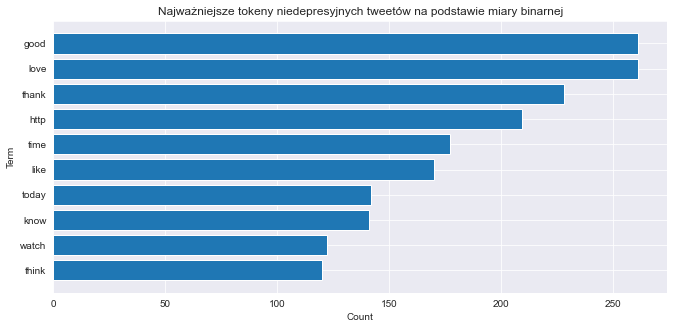

+-----------------------------------------------------+
| Najważniejsze tokeny niedepresyjnych tweetów na podstawie miary binarnej |
+--------------------------+--------------------------+
|           Term           |          Count           |
+--------------------------+--------------------------+
|           good           |           261            |
|           love           |           261            |
|          thank           |           228            |
|           http           |           209            |
|           time           |           177            |
|           like           |           170            |
|          today           |           142            |
|           know           |           141            |
|          watch           |           122            |
|          think           |           120            |
+--------------------------+--------------------------+


In [13]:
print(plot_table_most_important(top_tokens(count_transform_positive.toarray().sum(axis=0), vectorizer_count.get_feature_names_out(), 10),
        "Top 10 najczęsciej występujacych tokenów w tweetach osób z depresją"))

print('\n')
print(plot_table_most_important(top_tokens(count_transform_negative.toarray().sum(axis=0), vectorizer_count.get_feature_names_out(), 10),
        "Top 10 najczęsciej występujacych tokenów w tweetach osób bez depresji"))

print('\n')
print(plot_table_most_important(top_tokens(tfid_transform_positive.toarray().sum(axis=0), vectorizer_tfid.get_feature_names_out(), 10),
        "Top 10 tokenów depresyjnych tweetów na podstawie miary TF-IDF"))

print('\n')
print(plot_table_most_important(top_tokens(tfid_transform_negative.toarray().sum(axis=0), vectorizer_tfid.get_feature_names_out(), 10),
        "Top 10 tokenów niedepresyjnych tweetów na podstawie miary TF-IDF"))

print('\n')
print(plot_table_most_important(top_tokens(binary_transform_positive.toarray().sum(axis=0), vectorizer_binary.get_feature_names_out(), 10),
        "Najważniejsze tokeny depresyjnych tweetów na podstawie miary binarnej"))

print('\n')
print(plot_table_most_important(top_tokens(binary_transform_negative.toarray().sum(axis=0), vectorizer_binary.get_feature_names_out(), 10),
        "Najważniejsze tokeny niedepresyjnych tweetów na podstawie miary binarnej"))


Podział na zbiór testowy i treningowy

In [14]:
x_train, x_test, y_train, y_test = train_test_split(count_transform_general, df['label'], test_size=0.2, random_state=42, stratify = df['label'])

Trenowanie klasyfikatorów

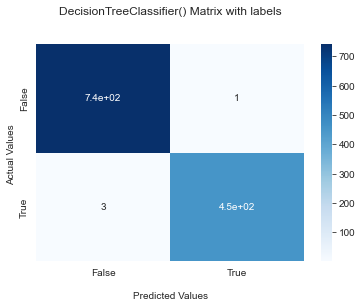

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       743
           1       1.00      0.99      1.00       457

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



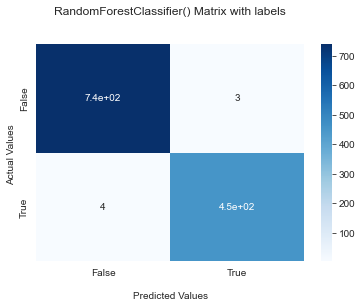

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       743
           1       0.99      0.99      0.99       457

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



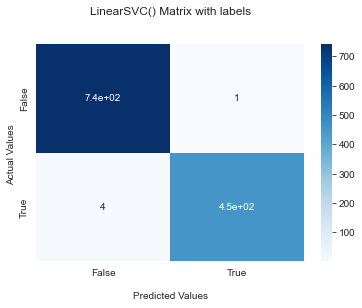

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       743
           1       1.00      0.99      0.99       457

    accuracy                           1.00      1200
   macro avg       1.00      0.99      1.00      1200
weighted avg       1.00      1.00      1.00      1200



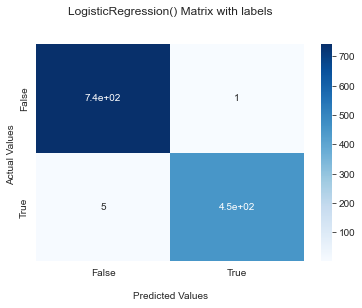

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       743
           1       1.00      0.99      0.99       457

    accuracy                           0.99      1200
   macro avg       1.00      0.99      0.99      1200
weighted avg       1.00      0.99      0.99      1200



In [34]:
classifiers = [DecisionTreeClassifier(), RandomForestClassifier(),
                   LinearSVC(), LogisticRegression()]

for clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
    ax.set_title(f'{clf} Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
    plt.show()
    print(classification_report(y_test, y_pred, labels=df["label"].unique()))
    # print(f"{clf} Accuracy: {round(accuracy_score(y_test, y_pred), 2)}, recall: {round(recall_score(y_test, y_pred),2)}, precision: {round(precision_score(y_test, y_pred),2)}")


end_time = datetime.now()

#print('Duration: {}'.format(end_time - start_time))

Opis dla LogisticRegression
Recall:
Ok. 100% spośród wszystkich rekordów z rzeczywistym label "0" zostały oznaczone poprawnie.
Ok. 99% spośród wszystkich rekordów z rzeczywistym label "1" zostały oznaczone poprawnie.

Precision:
Ok. 99% spośród rekordów, które klasyfikator określił jako "0", zostały oznaczone poprawnie.
Ok. 100% spośród rekordów, które klasyfikator określił jako "1", zostały oznaczone poprawnie.